# Analyze Metrics and Conduct Inference.ipynb

In [45]:
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import simpledorff
import math


In [46]:
# Load Combined_Data.xlsx
combined_data = pd.read_excel('Combined_Data.xlsx')

# GSM8k data - limit to task = "gsm8k"
gsm8k_data = combined_data[combined_data['task'] == 'gsm8k']

# Creative writing data - limit to task = "cw"
cw_data = combined_data[combined_data['task'] == 'cw']

# Load direct_prompting_comparison.xlsx
direct_prompting_comparison = pd.read_excel('direct_prompting_comparison.xlsx')


### A closer look at creative writing scores

In [47]:
# Summary statistics for variables: coherence_1_incoherent_10_very_coherent, Prediction_Based_On_First_10, Prediction_Based_On_Last_10, Aggegated_Prediction
print(cw_data[['coherence_1_incoherent_10_very_coherent', 'Prediction_Based_On_First_10', 'Prediction_Based_On_Last_10', 'Aggegated_Prediction']].describe())


       coherence_1_incoherent_10_very_coherent  Prediction_Based_On_First_10  \
count                              1600.000000                   1440.000000   
mean                                  4.974375                      5.403472   
std                                   2.612563                      2.175833   
min                                   1.000000                      1.000000   
25%                                   3.000000                      3.000000   
50%                                   5.000000                      7.000000   
75%                                   7.000000                      7.000000   
max                                  10.000000                      8.000000   

       Prediction_Based_On_Last_10  Aggegated_Prediction  
count                  1440.000000           1600.000000  
mean                      4.066667              4.722500  
std                       2.569885              2.265422  
min                       1.000000         

DescribeResult(nobs=1600, minmax=(-7.0, 8.0), mean=0.251875, variance=5.838020247029392, skewness=-0.006411691981771768, kurtosis=0.18078123260822876)


(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         16.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   6.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,  23.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

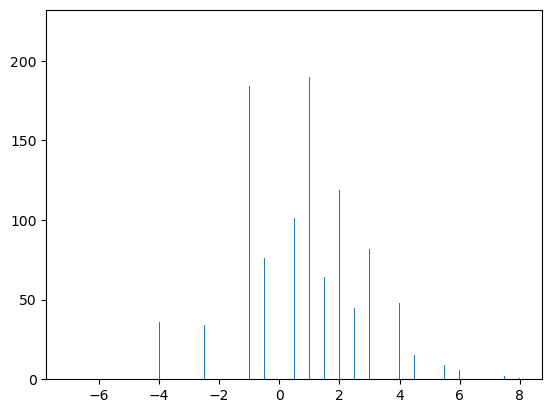

In [48]:
# Differences between coherence_1_incoherent_10_very_coherent and Aggregated_Prediction
print(stats.describe(cw_data['coherence_1_incoherent_10_very_coherent'] - cw_data['Aggegated_Prediction']))

# Histogram
plt.hist(cw_data['coherence_1_incoherent_10_very_coherent'] - cw_data['Aggegated_Prediction'], bins = 1000)


In [49]:
print(cw_data.columns)


Index(['model_task_method', 'conversation_number',
       'coherence_1_incoherent_10_very_coherent',
       'task_constraints_followed_0_not_followed_1_followed',
       'ease_of_review_1_easy_10_hard', 'correct',
       'Prediction_Based_On_First_10', 'Prediction_Based_On_Last_10',
       'Aggegated_Prediction', 'conversation_length', 'input_length',
       'output_length', 'conversation_cost', 'gsm8k_question_index',
       'gsm8k_answer', 'gsm8k_length_vs_provided',
       'length_vs_direct_prompting', 'num_linebreaks', 'num_sentences',
       'num_step_i', 'num_1_dot_etc', 'sentence_length', 'fres',
       'num_linebreaks_prompts', 'num_sentences_prompts', 'num_step_i_prompts',
       'num_1_dot_etc_prompts', 'sentence_length_prompts', 'fres_prompts',
       'num_linebreaks_provided', 'num_sentences_provided',
       'num_step_i_provided', 'num_1_dot_etc_provided', 'compliance',
       'coherence_1_incoherent_10_very_coherent_compliance_adjusted', 'model',
       'task', 'method', 

In [50]:
# Krippendorff's alpha
# I am using the simpledorff package
# experiment_col should be the conversation (row of the dataframe) - create model_task_method_conversation_id
# annotator_col should be 'Human', 'GPT-3.5 - First 10', 'GPT-3.5 - Last 10'
# class col should be the score from coherence_1_incoherent_10_very_coherent, Prediction_Based_On_First_10, Prediction_Based_On_Last_10

# Manipulate and reshape dataframe
cw_data['model_task_method_conversation_id'] = cw_data['model'] + '_' + cw_data['task'] + '_' + cw_data['method'] + '_' + cw_data['conversation_number'].astype(str)
cw_data['Human'] = cw_data['coherence_1_incoherent_10_very_coherent']
cw_data['GPT-3.5 - First 10'] = cw_data['Prediction_Based_On_First_10']
cw_data['GPT-3.5 - Last 10'] = cw_data['Prediction_Based_On_Last_10']
ka_data = cw_data[['model_task_method_conversation_id', 'Human', 'GPT-3.5 - First 10', 'GPT-3.5 - Last 10']]
ka_data_melted = ka_data.melt(id_vars=['model_task_method_conversation_id'], value_vars=['Human', 'GPT-3.5 - First 10', 'GPT-3.5 - Last 10'])
ka_data_melted = ka_data_melted.rename(columns={'variable': 'grader', 'value': 'coherence_score'})

# Calculate Krippendorff's alpha
print('overall KA')
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_melted,
                                                 experiment_col='model_task_method_conversation_id',
                                                 annotator_col='grader',
                                                 class_col='coherence_score'))

# Version excluding first 10
ka_data_no_first_10 = cw_data[cw_data['conversation_number'] > 10][['model_task_method_conversation_id', 'Human', 'GPT-3.5 - First 10', 'GPT-3.5 - Last 10']]
ka_data_no_first_10_melted = ka_data_no_first_10.melt(id_vars=['model_task_method_conversation_id'], value_vars=['Human', 'GPT-3.5 - First 10', 'GPT-3.5 - Last 10'])
ka_data_no_first_10_melted = ka_data_no_first_10_melted.rename(columns={'variable': 'grader', 'value': 'coherence_score'})
print('no first 10 KA')
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_no_first_10_melted,
                                                 experiment_col='model_task_method_conversation_id',
                                                 annotator_col='grader',
                                                 class_col='coherence_score'))

# Version excluding last 10
ka_data_no_last_10 = cw_data[cw_data['conversation_number'] <= 90][['model_task_method_conversation_id', 'Human', 'GPT-3.5 - First 10', 'GPT-3.5 - Last 10']]
ka_data_no_last_10_melted = ka_data_no_last_10.melt(id_vars=['model_task_method_conversation_id'], value_vars=['Human', 'GPT-3.5 - First 10', 'GPT-3.5 - Last 10'])
ka_data_no_last_10_melted = ka_data_no_last_10_melted.rename(columns={'variable': 'grader', 'value': 'coherence_score'})
print('no last 10 KA')
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_no_last_10_melted,
                                                 experiment_col='model_task_method_conversation_id',
                                                 annotator_col='grader',
                                                 class_col='coherence_score'))

# Version excluding first and last 10
ka_data_no_first_last_10 = cw_data[(cw_data['conversation_number'] > 10) & (cw_data['conversation_number'] <= 90)][['model_task_method_conversation_id', 'Human', 'GPT-3.5 - First 10', 'GPT-3.5 - Last 10']]
ka_data_no_first_last_10_melted = ka_data_no_first_last_10.melt(id_vars=['model_task_method_conversation_id'], value_vars=['Human', 'GPT-3.5 - First 10', 'GPT-3.5 - Last 10'])
ka_data_no_first_last_10_melted = ka_data_no_first_last_10_melted.rename(columns={'variable': 'grader', 'value': 'coherence_score'})
print('no first and last 10 KA')
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_no_first_last_10_melted,
                                                 experiment_col='model_task_method_conversation_id',
                                                 annotator_col='grader',
                                                 class_col='coherence_score'))


overall KA
0.10686929311619198
no first 10 KA


C:\Users\ijyli\AppData\Local\Temp\ipykernel_3888\1729583903.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cw_data['model_task_method_conversation_id'] = cw_data['model'] + '_' + cw_data['task'] + '_' + cw_data['method'] + '_' + cw_data['conversation_number'].astype(str)
C:\Users\ijyli\AppData\Local\Temp\ipykernel_3888\1729583903.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cw_data['Human'] = cw_data['coherence_1_incoherent_10_very_coherent']
C:\Users\ijyli\AppData\Local\Temp\ipykernel_3888\1729

0.10782815485733388
no last 10 KA
0.11024510661584563
no first and last 10 KA
0.11158211702182685


In [51]:
# Try aggregated predictions
ka_data_agg = cw_data[['model_task_method_conversation_id', 'Human', 'Aggegated_Prediction']]
ka_data_agg_melted = ka_data_agg.melt(id_vars=['model_task_method_conversation_id'], value_vars=['Human', 'Aggegated_Prediction'])
ka_data_agg_melted = ka_data_agg_melted.rename(columns={'variable': 'grader', 'value': 'coherence_score'})
print('aggregated predictions KA')
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_agg_melted,
                                                 experiment_col='model_task_method_conversation_id',
                                                 annotator_col='grader',
                                                 class_col='coherence_score'))


aggregated predictions KA
0.04803932294886726


In [55]:
# Try to demand less of the data - in ka_data_melted, bin 1-10 into 1-5
# Divide by 2 and take the ceiling
ka_data_melted['coherence_1_to_5'] = ka_data_melted.dropna()['coherence_score'].apply(lambda x: math.ceil(x/2))

# Calculate Krippendorff's alpha
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_melted,
                                                       experiment_col='model_task_method_conversation_id',
                                                       annotator_col='grader',
                                                       class_col='coherence_1_to_5'))


0.18525258256529475


In [57]:
# Try coherence on a scale of 1 to 3
ka_data_melted['coherence_1_to_3'] = ka_data_melted.dropna()['coherence_score'].apply(lambda x: math.ceil(x/3.33))

# Calculate Krippendorff's alpha
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_melted,
                                                       experiment_col='model_task_method_conversation_id',
                                                       annotator_col='grader',
                                                       class_col='coherence_1_to_3'))


0.2735720914000721


In [58]:
# Try coherence vs incoherence binary
ka_data_melted['coherence_binary'] = ka_data_melted.dropna()['coherence_score'].apply(lambda x: 1 if x > 5 else 0)

# Calculate Krippendorff's alpha
print(simpledorff.calculate_krippendorffs_alpha_for_df(ka_data_melted,
                                                       experiment_col='model_task_method_conversation_id',
                                                       annotator_col='grader',
                                                       class_col='coherence_binary'))


0.4195238892015637


In [ ]:
# Loop over cases where task = "cw" and output histograms of accuracy quality by model and method
# Loop over models
for model in cw_data['model'].unique():
    # Loop over methods
    for method in cw_data['method'].unique():
        # Get data for this model and method
        data = cw_data[(cw_data['model'] == model) & (cw_data['method'] == method)]
        # Plot histogram
        plt.hist(data['coherence_1_incoherent_10_very_coherent'], bins = 10)
        # Ticks for values of 1, 2, ... 10
        plt.xticks(range(1, 11))
        plt.title(model + ' - ' + method)
        plt.xlabel('Accuracy Quality')
        plt.ylabel('Count')
        # Save histogram
        plt.savefig('../Output/cw_acc_qual_' + model + '_' + method + '.png')
        plt.close()


## Accuracy/Quality

In [ ]:
# Average accuracy_quality by model, method, task
# Also get variance
avg_accuracy_quality_with_variance = combined_data[['model', 'method', 'task', 'accuracy_quality']].groupby(['model', 'method', 'task']).agg(['mean', 'var'])['accuracy_quality'].reset_index()

# Combine mean and variance into one column that is a string with the mean and then the variance in parentheses
avg_accuracy_quality_with_variance['accuracy_quality'] = avg_accuracy_quality_with_variance.apply(lambda row: str(round(row['mean'], 2)) + ' (' + str(round(row['var'], 2)) + ')', axis=1)

avg_accuracy_quality_with_variance


,model,method,task,mean,var,accuracy_quality
0,gpt4,ape_zero_shot_cot,cw,5.46,6.210505,5.46 (6.21)
1,gpt4,ape_zero_shot_cot,gsm8k,0.93,0.065758,0.93 (0.07)
2,gpt4,direct_prompting,cw,5.71,7.298889,5.71 (7.3)
3,gpt4,direct_prompting,gsm8k,0.73,0.199091,0.73 (0.2)
4,gpt4,least_to_most,cw,5.54,5.907475,5.54 (5.91)
5,gpt4,least_to_most,gsm8k,0.95,0.047980,0.95 (0.05)
6,gpt4,manual_cot,cw,6.33,5.193030,6.33 (5.19)
7,gpt4,manual_cot,gsm8k,0.93,0.065758,0.93 (0.07)
8,gpt4,manual_few_shot,cw,6.11,6.220101,6.11 (6.22)
9,gpt4,manual_few_shot,gsm8k,0.49,0.252424,0.49 (0.25)


In [ ]:
# Pivot table - column method should go wide
avg_accuracy_quality_pivot = avg_accuracy_quality_with_variance.drop(columns=['mean', 'var']).set_index(['model', 'task', 'method']).unstack()
#pivot_table(index=['model', 'task'], columns='method', values='accuracy_quality').reset_index()

# Fix axis
avg_accuracy_quality_pivot = avg_accuracy_quality_pivot.rename_axis([None, None], axis=1).reset_index()

# Sort rows by task - gsm8k task first, then cw
# Sort by model - text-davinci-003 first, then gpt4
avg_accuracy_quality_pivot = avg_accuracy_quality_pivot.sort_values(by=['task', 'model'], ascending=[True, True]).reset_index().drop(columns=['index'])

print(avg_accuracy_quality_pivot.columns)

flattened_cols = [''.join(col).strip().replace('accuracy_quality', '') for col in avg_accuracy_quality_pivot.columns.values]
avg_accuracy_quality_pivot.columns = flattened_cols

print(avg_accuracy_quality_pivot)

# Order columns: direct_prompting, zero_shot_cot, ape_zero_shot_cot, tree_of_thought, self_refine, least_to_most, manual_few_shot, manual_cot
avg_accuracy_quality_pivot = avg_accuracy_quality_pivot[['model', 'task', 'direct_prompting', 'zero_shot_cot', 'ape_zero_shot_cot', 'tree_of_thought', 'self_refine', 'least_to_most', 'manual_few_shot', 'manual_cot']]

# Output to LaTeX
avg_accuracy_quality_pivot.to_latex('../Output/avg_accuracy_quality_pivot.tex', index=False)


MultiIndex([(           'model',                  ''),
            (            'task',                  ''),
            ('accuracy_quality', 'ape_zero_shot_cot'),
            ('accuracy_quality',  'direct_prompting'),
            ('accuracy_quality',     'least_to_most'),
            ('accuracy_quality',        'manual_cot'),
            ('accuracy_quality',   'manual_few_shot'),
            ('accuracy_quality',       'self_refine'),
            ('accuracy_quality',   'tree_of_thought'),
            ('accuracy_quality',     'zero_shot_cot')],
           )
  model   task ape_zero_shot_cot direct_prompting least_to_most   manual_cot  \
0  gpt4     cw       5.46 (6.21)       5.71 (7.3)   5.54 (5.91)  6.33 (5.19)   
1   td3     cw        3.9 (5.36)      4.46 (7.79)   4.45 (5.28)  4.14 (4.89)   
2  gpt4  gsm8k       0.93 (0.07)       0.73 (0.2)   0.95 (0.05)  0.93 (0.07)   
3   td3  gsm8k       0.49 (0.25)      0.23 (0.18)   0.67 (0.95)   0.6 (0.24)   

  manual_few_shot  self_refine tree

C:\Users\ijyli\AppData\Local\Temp\ipykernel_3888\280831353.py:10: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  avg_accuracy_quality_pivot = avg_accuracy_quality_pivot.sort_values(by=['task', 'model'], ascending=[True, True]).reset_index().drop(columns=['index'])


## Adding release date to accuracy quality table (optional version)

In [ ]:
# Release date and gains versus direct prompting

# Load Excel file "..\Selection of Prompt Engineering Methods\Hand-Labeled Method and Implementation Considerations.xlsx"
hand_labeled_data = pd.read_excel('..\Selection of Prompt Engineering Methods\Hand-Labeled Method and Implementation Considerations.xlsx')

# Keep columns ss_publication_date, "Prompt Engineering Method"
hand_labeled_data = hand_labeled_data[['ss_publication_date', 'Prompt Engineering Method']]

# Mapping names from this data to technqiue names
# "Few-Shot Learing" -> "manual_few_shot"
# "Chain-of-Thought Prompting" -> "manual_cot"
# "Zero-Shot Chain-of_Thought" -> "zero_shot_cot"
# "Automatic Prompt Engineer" -> "ape_zero_shot_cot"
# "Self-Refine" -> "self_refine"
# "Least-to-Most Prompting" -> "least_to_most"
# "Tree-of-Thought" -> "tree_of_thought"
# Set names in hand_labeled_data to these names
hand_labeled_data['technique_name'] = hand_labeled_data['Prompt Engineering Method'].replace({'Few-Shot Learning': 'manual_few_shot', 'Chain-of-Thought Prompting': 'manual_cot', 'Zero-Shot Chain-of-Thought': 'zero_shot_cot', 'Automatic Prompt Engineer': 'ape_zero_shot_cot', 'Self-Refine': 'self_refine', 'Least-to-Most Prompting': 'least_to_most', 'Tree-of-Thought': 'tree_of_thought'})

# Keep cases where technique_name is not 'Prompt Engineering Method'
hand_labeled_data = hand_labeled_data[hand_labeled_data['technique_name'] != hand_labeled_data['Prompt Engineering Method']]

# Convert ss_publication_date to "YYYY-MM-DD"
hand_labeled_data['ss_publication_date'] = hand_labeled_data['ss_publication_date'].dt.strftime('%Y-%m-%d')

# Drop the item with technique_name = 'tree_of_thought' that has the higher ss_publication_date
# Just keep the row with min ss_publication_date for each technique_name
hand_labeled_data = hand_labeled_data.groupby(['technique_name']).min().reset_index()
print(hand_labeled_data)

# Add ss_publication_date to avg_accuracy_quality_pivot
# The value should be for each column, right below the column name
# Transpose accuracy_quality_pivot
avg_accuracy_quality_pivot_transposed = avg_accuracy_quality_pivot.transpose().reset_index()

# Set name of first column to "technique_name"
avg_accuracy_quality_pivot_transposed = avg_accuracy_quality_pivot_transposed.rename(columns={'index': 'technique_name'})

# Left join hand_labeled_data to avg_accuracy_quality_pivot_transposed on technique_name
avg_accuracy_quality_pivot_transposed = avg_accuracy_quality_pivot_transposed.merge(hand_labeled_data, on='technique_name', how='left')

# Transpose back
avg_accuracy_quality_pivot_with_date = avg_accuracy_quality_pivot_transposed.transpose().reset_index()

# # Set names to last row
# avg_accuracy_quality_pivot_with_date.columns = avg_accuracy_quality_pivot_with_date.iloc[-1]
# # Drop first row, reset index
# avg_accuracy_quality_pivot_with_date = avg_accuracy_quality_pivot_with_date.drop([0]).reset_index().drop(columns=['index'])
# # Drop row where technique_name is "Prompt Engineering Method"
# #avg_accuracy_quality_pivot_with_date = avg_accuracy_quality_pivot_with_date[avg_accuracy_quality_pivot_with_date['technique_name'] != 'Prompt Engineering Method']
# # In first column, set values of "0", "1", "2", "3" to blanks
# #avg_accuracy_quality_pivot_with_date['technique_name'] = avg_accuracy_quality_pivot_with_date['technique_name'].replace({'0': '', '1': '', '2': '', '3': ''})
# # Drop column tecnique_name
# #avg_accuracy_quality_pivot_with_date = avg_accuracy_quality_pivot_with_date.drop(columns=['technique_name'])
# # Drop first column
# avg_accuracy_quality_pivot_with_date = avg_accuracy_quality_pivot_with_date.iloc[:, 1:]
# # Set second column name to "Model"
# avg_accuracy_quality_pivot_with_date = avg_accuracy_quality_pivot_with_date.rename(index={1: 'Model'})
# # Set third column name to "Task"
# avg_accuracy_quality_pivot_with_date = avg_accuracy_quality_pivot_with_date.rename(index={2: 'Task'})
# avg_accuracy_quality_pivot_with_date.rename(columns={avg_accuracy_quality_pivot_with_date.columns[0]: 'Model'}, inplace=True)
# avg_accuracy_quality_pivot_with_date.rename(columns={avg_accuracy_quality_pivot_with_date.columns[1]: 'Task'}, inplace=True)
# Drop bottom row
#avg_accuracy_quality_pivot_with_date = avg_accuracy_quality_pivot_with_date.drop([avg_accuracy_quality_pivot_with_date.index[-1]])
# Move bottom row to top
#avg_accuracy_quality_pivot_with_date = pd.concat([avg_accuracy_quality_pivot_with_date.iloc[[-1]], avg_accuracy_quality_pivot_with_date.iloc[:-1]]).reset_index().drop(columns=['index'])
# Set column names
#new_part = ['Model', 'Task', 'Direct Prompting']
#new_names = new_part.extend(avg_accuracy_quality_pivot_with_date.columns[3:])
#avg_accuracy_quality_pivot_with_date.columns = new_names
# avg_accuracy_quality_pivot_with_date.columns = ['Model', 'Task', 'Zero-Shot Chain-of-Thought', 'Automatic Prompt Engineer', 'Tree-of-Thought',                'Self-Refine',
#           'Least-to-Most Prompting',          'Few-Shot Learning',
#        'Chain-of-Thought Prompting']
print(avg_accuracy_quality_pivot_with_date.columns)

# Output to LaTeX
print(avg_accuracy_quality_pivot_with_date)
avg_accuracy_quality_pivot_with_date.to_latex('../Output/avg_accuracy_quality_pivot_with_date.tex', index=False)


      technique_name ss_publication_date   Prompt Engineering Method
0  ape_zero_shot_cot          2022-11-03   Automatic Prompt Engineer
1      least_to_most          2022-05-21     Least-to-Most Prompting
2         manual_cot          2022-01-28  Chain-of-Thought Prompting
3    manual_few_shot          2020-05-28           Few-Shot Learning
4        self_refine          2023-03-30                 Self-Refine
5    tree_of_thought          2023-05-15             Tree-of-Thought
6      zero_shot_cot          2022-05-24  Zero-Shot Chain-of-Thought
Index(['index', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='object')
                       index      0      1                 2  \
0             technique_name  model   task  direct_prompting   
1                          0   gpt4     cw        5.71 (7.3)   
2                          1    td3     cw       4.46 (7.79)   
3                          2   gpt4  gsm8k        0.73 (0.2)   
4                          3    td3  gsm8k       0.23 (0.18)   
5